# 패키지

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 데이터 소수점 지정
pd.options.display.precision = 2

# 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.family'] = 'Malgun Gothic'




# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드

In [3]:
customer = pd.read_csv('telco_customer.csv', encoding='euc-kr', parse_dates=['EndDateTmp', 'StartDate'])
charge_df = pd.read_csv('telco_charge.csv', encoding='euc-kr')

In [4]:
print('telco_customer : ', customer.shape)
print('telco_charge : ', charge_df.shape)

telco_customer :  (6863, 28)
telco_charge :  (291334, 3)


# 이상치 판단

- 1) IQR 기준 : 2사분위 + 1.5 * IQR    
           3사분위 + 1.5 * IQR
- 2) ESD 기준 : 평균 +- 3 * std

##### @TenureMonths : 서비스 사용시간

In [9]:
customer['StartDate'] = pd.to_datetime(customer['StartDate'])
customer['EndDateTmp'] = pd.to_datetime(customer['EndDateTmp'])
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6863 entries, 0 to 6862
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   CustomerId            6863 non-null   object        
 1   Gender                6863 non-null   object        
 2   Age                   6863 non-null   int64         
 3   AgeGroup              6863 non-null   object        
 4   Married               6863 non-null   object        
 5   Dependents            6863 non-null   object        
 6   noDependents          6863 non-null   int64         
 7   Referrals             6863 non-null   object        
 8   noReferrals           6863 non-null   int64         
 9   PaperlessBilling      6863 non-null   object        
 10  PaymentMethod         6863 non-null   object        
 11  OnlineSecurity        6863 non-null   object        
 12  OnlineBackup          6863 non-null   object        
 13  TechSupport       

In [10]:
#df_raw에 파생변수 합해서 만들기(TenureMonths)

def diff_month(d1, d2):
    return (d2.dt.year - d1.dt.year) * 12 + d2.dt.month - d1.dt.month

customer['TenureMonths'] = diff_month(pd.to_datetime(customer['StartDate']),pd.to_datetime(customer['EndDateTmp']))
customer

,CustomerId,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,...,ChurnLabel,ChurnScore,ChurnCategory,ChurnReason,CustomerLTV,SatisScore,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths
0,C-10001,여성,37,30대,Yes,No,0,Yes,2,Yes,...,No,65,NaN,NaN,2205,3,0,47910,431100,21
1,C-10002,남성,46,40대,No,No,0,No,0,No,...,No,66,NaN,NaN,5414,5,11300,12090,108710,21
2,C-10003,남성,50,50대,No,No,0,No,0,Yes,...,Yes,71,Competitor,Price too high,4479,1,0,38080,152100,4
3,C-10004,남성,78,70대,Yes,No,0,Yes,1,Yes,...,Yes,99,Dissatisfaction,Product dissatisfaction,3714,1,0,31410,408720,13
4,C-10005,여성,75,70대,Yes,No,0,Yes,3,Yes,...,Yes,68,Dissatisfaction,Network reliability,3464,1,0,8360,24970,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,C-17039,여성,20,20대,No,No,0,No,0,No,...,No,59,NaN,NaN,3161,4,0,52770,685680,25
6859,C-17040,남성,40,40대,Yes,No,0,Yes,1,Yes,...,Yes,68,Dissatisfaction,Product dissatisfaction,5248,1,0,18310,402730,22
6860,C-17041,남성,22,20대,No,No,0,No,0,Yes,...,No,33,NaN,NaN,5870,5,0,21020,42040,14
6861,C-17042,남성,21,20대,No,No,0,Yes,5,No,...,No,59,NaN,NaN,4792,3,0,2370,160460,79


##### @AvgCharge : 평균과금액(원/월)

In [11]:
charge_df

,CustomerId,ChargeDate,ChargeAmt
0,C-10001,2020-04-01,84600
1,C-10001,2020-05-01,83500
2,C-10001,2020-06-01,85700
3,C-10001,2020-07-01,83500
4,C-10001,2020-08-01,84600
...,...,...,...
291329,C-17043,2021-08-01,68300
291330,C-17043,2021-09-01,69500
291331,C-17043,2021-10-01,68300
291332,C-17043,2021-11-01,69500


In [12]:
AvgCharge = charge_df.groupby('CustomerId')['ChargeAmt'].agg(**{'AvgCharge':'mean'}).reset_index()

In [13]:
AvgCharge

,CustomerId,AvgCharge
0,C-10001,83590.48
1,C-10002,68928.57
2,C-10003,98180.00
3,C-10004,112742.86
4,C-10005,94500.00
...,...,...
6858,C-17039,64428.00
6859,C-17040,101891.30
6860,C-17041,56600.00
6861,C-17042,80107.59


##### @TotalCharge : 총 과금액(원)

In [14]:
TotalCharge = charge_df.groupby('CustomerId')['ChargeAmt'].agg(**{'TotalCharge':'sum'}).reset_index()

In [15]:
TotalCharge

,CustomerId,TotalCharge
0,C-10001,1755400
1,C-10002,1447500
2,C-10003,490900
3,C-10004,1578400
4,C-10005,378000
...,...,...
6858,C-17039,1610700
6859,C-17040,2343500
6860,C-17041,792400
6861,C-17042,6328500


###### @customer 데이터 합치기

In [16]:
df_raw = pd.merge(customer, AvgCharge)

In [17]:
df_raw = pd.merge(df_raw, TotalCharge)

- IQR 기준으로 이상치 판단

##### @noDependents

In [6]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  print(lowest, highest)
    

  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [62]:
df_raw[(df_raw['noDependents'] > 3.46) & (df_raw['ChurnLabel'] == 1)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue


In [63]:
df_raw[(df_raw['noDependents'] > 3.46) & (df_raw['ChurnLabel'] == 0)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
2443,0,44,40대,1,1,4,1,10,1,0,...,0,37290,2685670,84,128775.00,10817100,13502770,31972,0,160747
3334,0,49,40대,1,1,4,1,8,0,2,...,0,48140,96160,14,66907.14,936700,1032860,6868,0,73775
5291,1,48,40대,1,1,4,1,1,1,0,...,0,47350,2558550,66,24093.94,1590200,4148750,38765,0,62859


No (3), Yes (0) => 0%

In [64]:
get_outlier(df=df_raw, column='noDependents')

0.0 0.0


Int64Index([   5,    9,   11,   15,   16,   22,   25,   26,   28,   33,
            ...
            6824, 6831, 6834, 6838, 6841, 6847, 6848, 6851, 6852, 6854],
           dtype='int64', length=1453)

In [65]:
df_raw[(df_raw['noDependents'] > 0) & (df_raw['ChurnLabel'] == 1)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
53,1,78,70대,0,1,1,0,0,1,0,...,135600,13110,144080,11,114758.33,1377100,1656780,13098,12327,150616
70,0,52,50대,1,1,1,1,1,0,0,...,0,0,0,37,46728.95,1775700,1775700,0,0,47991
157,1,50,50대,0,1,2,0,0,1,1,...,0,40120,360920,9,86330.00,863300,1224220,40102,0,136024
171,0,38,30대,0,1,1,0,0,1,0,...,0,50060,2454590,49,122844.00,6142200,8596790,50093,0,175444
270,0,21,20대,0,1,2,0,0,1,0,...,0,16500,49490,3,84300.00,337200,386690,16496,0,128896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6380,1,31,30대,0,1,2,0,0,1,0,...,0,13790,109840,8,116744.44,1050700,1160540,13730,0,145067
6420,0,51,50대,0,1,2,0,0,0,0,...,0,29040,232550,8,101266.67,911400,1143950,29068,0,142993
6449,1,39,30대,0,1,2,0,0,1,0,...,0,33220,132890,4,84020.00,420100,552990,33222,0,138247
6458,1,34,30대,0,1,1,0,0,1,1,...,0,4520,67120,15,116975.00,1871600,1938720,4474,0,129248


In [66]:
df_raw[(df_raw['noDependents'] > 0) & (df_raw['ChurnLabel'] == 0)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
5,1,23,20대,0,1,1,0,0,1,1,...,0,18980,170520,21,81852.38,1718900,1889420,8120,0,89972
9,1,43,40대,1,1,1,1,3,1,1,...,0,32210,2090390,77,106314.29,8186200,10276590,27147,0,133462
11,1,25,20대,1,1,2,1,2,1,1,...,0,18080,1302550,84,136686.90,11481700,12784250,15506,0,152193
15,1,58,50대,1,1,2,1,9,1,1,...,0,30850,2187120,83,112690.36,9353300,11540420,26350,0,139041
16,1,52,50대,1,1,1,0,0,0,1,...,0,0,0,46,71863.04,3305700,3305700,0,0,71863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6847,0,70,70대,1,1,1,1,7,1,0,...,33900,13220,451100,46,127632.61,5871100,6356100,9806,736,138176
6848,1,56,50대,1,1,1,1,2,1,0,...,0,55140,3690920,79,22634.18,1788100,5479020,46720,0,69354
6851,0,31,30대,0,1,1,0,0,1,1,...,0,25310,1620650,76,115781.58,8799400,10420050,21324,0,137105
6852,0,62,60대,1,1,3,0,0,0,1,...,0,8700,398660,58,22993.10,1333600,1732260,6873,0,29866


No(1362), yes(91) = 6%

##### @TotalRevenue : 총 매출액(원)

In [18]:
tmp = []
for a,b,c in zip(df_raw['TotalCharge'],df_raw['TotalExtraDataCharge'], df_raw['TotalRoamCharge']):
  dates = a + b + c
  tmp.append(dates)

df_raw['TotalRevenue'] = tmp
df_raw['TotalRevenue']

0       2186500
1       1567510
2        643000
3       1987120
4        402970
         ...   
6858    2296380
6859    2746230
6860     834440
6861    6488960
6862    5196100
Name: TotalRevenue, Length: 6863, dtype: int64

##### @MonthRoamCharge (**내가 만든 파생변수**)

In [19]:
df_raw['MonthRoamCharge'] =  (df_raw['TotalRoamCharge'] / df_raw['TenureMonths']).astype(int)

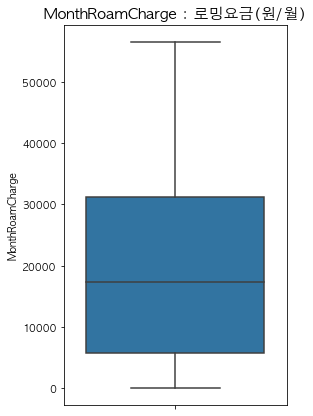

In [20]:
# 박스플롯으로 분포 확인해보기
plt.figure(figsize = (4, 7))
sns.boxplot(y = 'MonthRoamCharge', data = df_raw)
plt.title('MonthRoamCharge : 로밍요금(원/월)', size = 15)
plt.show()

##### @AvgExtraDataCharge (**내가 만든 파생변수**)

In [21]:
df_raw['AvgExtraDataCharge'] =  (df_raw['TotalExtraDataCharge'] / df_raw['TenureMonths']).astype(int)

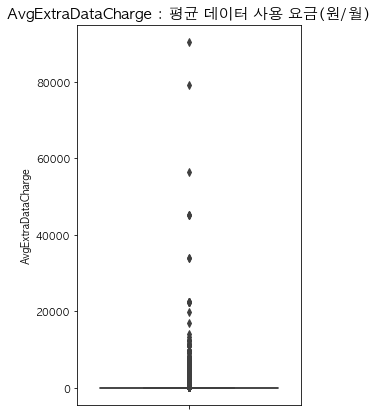

In [22]:
# 박스플롯으로 분포 확인해보기
plt.figure(figsize = (4, 7))
sns.boxplot(y = 'AvgExtraDataCharge', data = df_raw)
plt.title('AvgExtraDataCharge : 평균 데이터 사용 요금(원/월)', size = 15)
plt.show()

In [23]:
df_raw

,CustomerId,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,...,SatisScore,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge
0,C-10001,여성,37,30대,Yes,No,0,Yes,2,Yes,...,3,0,47910,431100,21,83590.48,1755400,2186500,20528,0
1,C-10002,남성,46,40대,No,No,0,No,0,No,...,5,11300,12090,108710,21,68928.57,1447500,1567510,5176,538
2,C-10003,남성,50,50대,No,No,0,No,0,Yes,...,1,0,38080,152100,4,98180.00,490900,643000,38025,0
3,C-10004,남성,78,70대,Yes,No,0,Yes,1,Yes,...,1,0,31410,408720,13,112742.86,1578400,1987120,31440,0
4,C-10005,여성,75,70대,Yes,No,0,Yes,3,Yes,...,1,0,8360,24970,3,94500.00,378000,402970,8323,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,C-17039,여성,20,20대,No,No,0,No,0,No,...,4,0,52770,685680,25,64428.00,1610700,2296380,27427,0
6859,C-17040,남성,40,40대,Yes,No,0,Yes,1,Yes,...,1,0,18310,402730,22,101891.30,2343500,2746230,18305,0
6860,C-17041,남성,22,20대,No,No,0,No,0,Yes,...,5,0,21020,42040,14,56600.00,792400,834440,3002,0
6861,C-17042,남성,21,20대,No,No,0,Yes,5,No,...,3,0,2370,160460,79,80107.59,6328500,6488960,2031,0


In [27]:
df_raw.groupby('ChurnLabel')['MonthRoamCharge'].describe()

,count,mean,std,min,25%,50%,75%,max
ChurnLabel,,,,,,,,
No,5161.0,17115.01,13565.71,0.0,4547.00,15141.0,27560.0,48043.0
Yes,1702.0,26236.60,17479.81,0.0,10590.25,26096.0,41225.5,56477.0


In [28]:
customer.groupby('ChurnLabel')['AvgRoamCharge'].describe()

,count,mean,std,min,25%,50%,75%,max
ChurnLabel,,,,,,,,
No,5161.0,25875.77,17477.49,0.0,10280.0,25880.0,41250.0,56500.0
Yes,1702.0,26240.90,17479.41,0.0,10620.0,26100.0,41250.0,56500.0


In [29]:
df_raw

,CustomerId,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,...,SatisScore,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge
0,C-10001,여성,37,30대,Yes,No,0,Yes,2,Yes,...,3,0,47910,431100,21,83590.48,1755400,2186500,20528,0
1,C-10002,남성,46,40대,No,No,0,No,0,No,...,5,11300,12090,108710,21,68928.57,1447500,1567510,5176,538
2,C-10003,남성,50,50대,No,No,0,No,0,Yes,...,1,0,38080,152100,4,98180.00,490900,643000,38025,0
3,C-10004,남성,78,70대,Yes,No,0,Yes,1,Yes,...,1,0,31410,408720,13,112742.86,1578400,1987120,31440,0
4,C-10005,여성,75,70대,Yes,No,0,Yes,3,Yes,...,1,0,8360,24970,3,94500.00,378000,402970,8323,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,C-17039,여성,20,20대,No,No,0,No,0,No,...,4,0,52770,685680,25,64428.00,1610700,2296380,27427,0
6859,C-17040,남성,40,40대,Yes,No,0,Yes,1,Yes,...,1,0,18310,402730,22,101891.30,2343500,2746230,18305,0
6860,C-17041,남성,22,20대,No,No,0,No,0,Yes,...,5,0,21020,42040,14,56600.00,792400,834440,3002,0
6861,C-17042,남성,21,20대,No,No,0,Yes,5,No,...,3,0,2370,160460,79,80107.59,6328500,6488960,2031,0


##### @AvgRevenue

In [30]:
df_raw['AvgRevenue'] = (df_raw['TotalRevenue'] / df_raw['TenureMonths']).astype(int)

In [31]:
df_raw

,CustomerId,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
0,C-10001,여성,37,30대,Yes,No,0,Yes,2,Yes,...,0,47910,431100,21,83590.48,1755400,2186500,20528,0,104119
1,C-10002,남성,46,40대,No,No,0,No,0,No,...,11300,12090,108710,21,68928.57,1447500,1567510,5176,538,74643
2,C-10003,남성,50,50대,No,No,0,No,0,Yes,...,0,38080,152100,4,98180.00,490900,643000,38025,0,160750
3,C-10004,남성,78,70대,Yes,No,0,Yes,1,Yes,...,0,31410,408720,13,112742.86,1578400,1987120,31440,0,152855
4,C-10005,여성,75,70대,Yes,No,0,Yes,3,Yes,...,0,8360,24970,3,94500.00,378000,402970,8323,0,134323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,C-17039,여성,20,20대,No,No,0,No,0,No,...,0,52770,685680,25,64428.00,1610700,2296380,27427,0,91855
6859,C-17040,남성,40,40대,Yes,No,0,Yes,1,Yes,...,0,18310,402730,22,101891.30,2343500,2746230,18305,0,124828
6860,C-17041,남성,22,20대,No,No,0,No,0,Yes,...,0,21020,42040,14,56600.00,792400,834440,3002,0,59602
6861,C-17042,남성,21,20대,No,No,0,Yes,5,No,...,0,2370,160460,79,80107.59,6328500,6488960,2031,0,82138


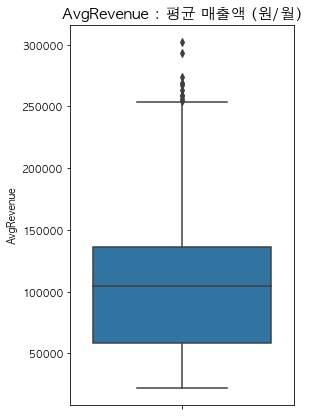

In [32]:
# 박스플롯으로 분포 확인해보기
plt.figure(figsize = (4, 7))
sns.boxplot(y = 'AvgRevenue', data = df_raw)
plt.title('AvgRevenue : 평균 매출액 (원/월)', size = 15)
plt.show()

In [69]:
get_outlier(df=df_raw, column='AvgRevenue')

-58776.25 253565.75


Int64Index([62, 2088, 2732, 3577, 3749, 4302, 4505, 4741, 5171, 6470], dtype='int64')

In [70]:
df_raw[(df_raw['AvgRevenue'] > 253565.75) & (df_raw['ChurnLabel'] == 1)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
62,0,59,50대,0,0,0,0,0,1,0,...,0,45990,45990,1,113850.0,227700,273690,45990,0,273690
2088,0,77,70대,0,0,0,0,0,1,0,...,11300,56050,56050,1,100900.0,201800,269150,56050,11300,269150
2732,1,68,60대,0,0,0,0,0,1,0,...,0,49270,49270,1,102600.0,205200,254470,49270,0,254470
3577,0,75,70대,0,0,0,0,0,1,0,...,90400,46560,46560,1,82600.0,165200,302160,46560,90400,302160
3749,0,32,30대,0,0,0,0,0,1,0,...,0,11750,11750,1,140700.0,281400,293150,11750,0,293150
4302,1,71,70대,0,0,0,0,0,1,0,...,0,48030,48030,1,107600.0,215200,263230,48030,0,263230
4505,0,59,50대,0,0,0,0,0,1,0,...,0,9040,9040,1,125300.0,250600,259640,9040,0,259640
4741,1,45,40대,0,0,0,0,0,0,1,...,0,36500,36500,1,109750.0,219500,256000,36500,0,256000
5171,0,25,20대,0,0,0,0,0,1,2,...,45200,25200,25200,1,93950.0,187900,258300,25200,45200,258300
6470,0,53,50대,1,0,0,1,1,0,0,...,56500,39780,39780,1,85500.0,171000,267280,39780,56500,267280


In [71]:
df_raw[(df_raw['AvgRevenue'] > 253565.75) & (df_raw['ChurnLabel'] == 0)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue


In [36]:
df_raw['AvgRevenue'].describe()

count      6863.00
mean     100697.67
std       46678.79
min       21976.00
25%       58352.00
50%      104878.00
75%      136437.50
max      302160.00
Name: AvgRevenue, dtype: float64

In [72]:
df_raw[(df_raw['AvgRevenue'] > 100697.67 + 3 * 46678.79) & (df_raw['ChurnLabel'] == 0)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue


In [73]:
df_raw[(df_raw['AvgRevenue'] > 100697.67 + 3 * 46678.79) & (df_raw['ChurnLabel'] == 1)]

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
62,0,59,50대,0,0,0,0,0,1,0,...,0,45990,45990,1,113850.0,227700,273690,45990,0,273690
136,0,23,20대,0,0,0,0,0,1,0,...,0,50400,50400,1,99300.0,198600,249000,50400,0,249000
198,0,25,20대,1,0,0,1,1,1,0,...,0,49380,49380,1,100150.0,200300,249680,49380,0,249680
2088,0,77,70대,0,0,0,0,0,1,0,...,11300,56050,56050,1,100900.0,201800,269150,56050,11300,269150
2610,0,44,40대,1,0,0,1,1,0,2,...,0,36610,36610,1,102450.0,204900,241510,36610,0,241510
2732,1,68,60대,0,0,0,0,0,1,0,...,0,49270,49270,1,102600.0,205200,254470,49270,0,254470
2804,0,67,60대,1,0,0,1,1,1,0,...,33900,19660,19660,1,95450.0,190900,244460,19660,33900,244460
3577,0,75,70대,0,0,0,0,0,1,0,...,90400,46560,46560,1,82600.0,165200,302160,46560,90400,302160
3749,0,32,30대,0,0,0,0,0,1,0,...,0,11750,11750,1,140700.0,281400,293150,11750,0,293150
3837,1,70,70대,0,0,0,0,0,1,0,...,45200,49160,49160,1,79500.0,159000,253360,49160,45200,253360


In [74]:
df_raw['ChurnLabel']

0       0
1       0
2       1
3       1
4       1
       ..
6858    0
6859    1
6860    0
6861    0
6862    0
Name: ChurnLabel, Length: 6863, dtype: int64

In [75]:
df_raw['ChurnLabel'] = df_raw['ChurnLabel'].replace(to_replace='Yes', value=1)
df_raw['ChurnLabel'] = df_raw['ChurnLabel'].replace(to_replace='No', value=0)

In [76]:
df_raw.to_csv('add_variable_customer.csv', encoding='CP949')

In [77]:
data = pd.read_csv('add_variable_customer.csv', encoding='euc-kr')

In [78]:
data.drop('Unnamed: 0', axis = 1, inplace=True)

In [79]:
df_raw=data

In [80]:
df_raw

,Gender,Age,AgeGroup,Married,Dependents,noDependents,Referrals,noReferrals,PaperlessBilling,PaymentMethod,...,TotalExtraDataCharge,AvgRoamCharge,TotalRoamCharge,TenureMonths,AvgCharge,TotalCharge,TotalRevenue,MonthRoamCharge,AvgExtraDataCharge,AvgRevenue
0,1,37,30대,1,0,0,1,2,1,1,...,0,47910,431100,21,83590.48,1755400,2186500,20528,0,104119
1,0,46,40대,0,0,0,0,0,0,1,...,11300,12090,108710,21,68928.57,1447500,1567510,5176,538,74643
2,0,50,50대,0,0,0,0,0,1,0,...,0,38080,152100,4,98180.00,490900,643000,38025,0,160750
3,0,78,70대,1,0,0,1,1,1,0,...,0,31410,408720,13,112742.86,1578400,1987120,31440,0,152855
4,1,75,70대,1,0,0,1,3,1,1,...,0,8360,24970,3,94500.00,378000,402970,8323,0,134323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,1,20,20대,0,0,0,0,0,0,1,...,0,52770,685680,25,64428.00,1610700,2296380,27427,0,91855
6859,0,40,40대,1,0,0,1,1,1,0,...,0,18310,402730,22,101891.30,2343500,2746230,18305,0,124828
6860,0,22,20대,0,0,0,0,0,1,1,...,0,21020,42040,14,56600.00,792400,834440,3002,0,59602
6861,0,21,20대,0,0,0,1,5,0,1,...,0,2370,160460,79,80107.59,6328500,6488960,2031,0,82138


##### @Gender : 여성(1), 남성(0)

In [81]:
df_raw['Gender'] = df_raw['Gender'].replace(to_replace='여성', value=1)
df_raw['Gender'] = df_raw['Gender'].replace(to_replace='남성', value=0)

##### @Married : Yes(1), No(0)

In [82]:
df_raw['Married'] = df_raw['Married'].replace(to_replace='Yes', value=1)
df_raw['Married'] = df_raw['Married'].replace(to_replace='No', value=0)

##### @Referrals : Yes(1), No(0)

In [83]:
df_raw['Referrals'] = df_raw['Referrals'].replace(to_replace='Yes', value=1)
df_raw['Referrals'] = df_raw['Referrals'].replace(to_replace='No', value=0)

##### @Dependents: Yes(1), No(0)

In [84]:
df_raw['Dependents'] = df_raw['Dependents'].replace(to_replace='Yes', value=1)
df_raw['Dependents'] = df_raw['Dependents'].replace(to_replace='No', value=0)

##### @PaperlessBilling  : Yes(1), No(0)

In [85]:
df_raw['PaperlessBilling'] = df_raw['PaperlessBilling'].replace(to_replace='Yes', value=1)
df_raw['PaperlessBilling'] = df_raw['PaperlessBilling'].replace(to_replace='No', value=0)

##### @PaymentMethod

In [86]:
df_raw['PaymentMethod'] = df_raw['PaymentMethod'].replace(to_replace='신용카드', value=1)
df_raw['PaymentMethod'] = df_raw['PaymentMethod'].replace(to_replace='계좌이체', value=0)
df_raw['PaymentMethod'] = df_raw['PaymentMethod'].replace(to_replace='이체/메일확인', value=2)

##### @OnlineSecurity

In [87]:
df_raw['OnlineSecurity'] = df_raw['OnlineSecurity'].replace(to_replace='Yes', value=1)
df_raw['OnlineSecurity'] = df_raw['OnlineSecurity'].replace(to_replace='No', value=0)

##### @OnlineBackup  : Yes(1), No(0)

In [88]:
df_raw['OnlineBackup'] = df_raw['OnlineBackup'].replace(to_replace='Yes', value=1)
df_raw['OnlineBackup'] = df_raw['OnlineBackup'].replace(to_replace='No', value=0)

##### @TechSupport  : Yes(1), No(0)

In [89]:
df_raw['TechSupport'] = df_raw['TechSupport'].replace(to_replace='Yes', value=1)
df_raw['TechSupport'] = df_raw['TechSupport'].replace(to_replace='No', value=0)

##### @UnlimitedData : Yes(1), No(0)

In [90]:
df_raw['UnlimitedData'] = df_raw['UnlimitedData'].replace(to_replace='Yes', value=1)
df_raw['UnlimitedData'] = df_raw['UnlimitedData'].replace(to_replace='No', value=0)

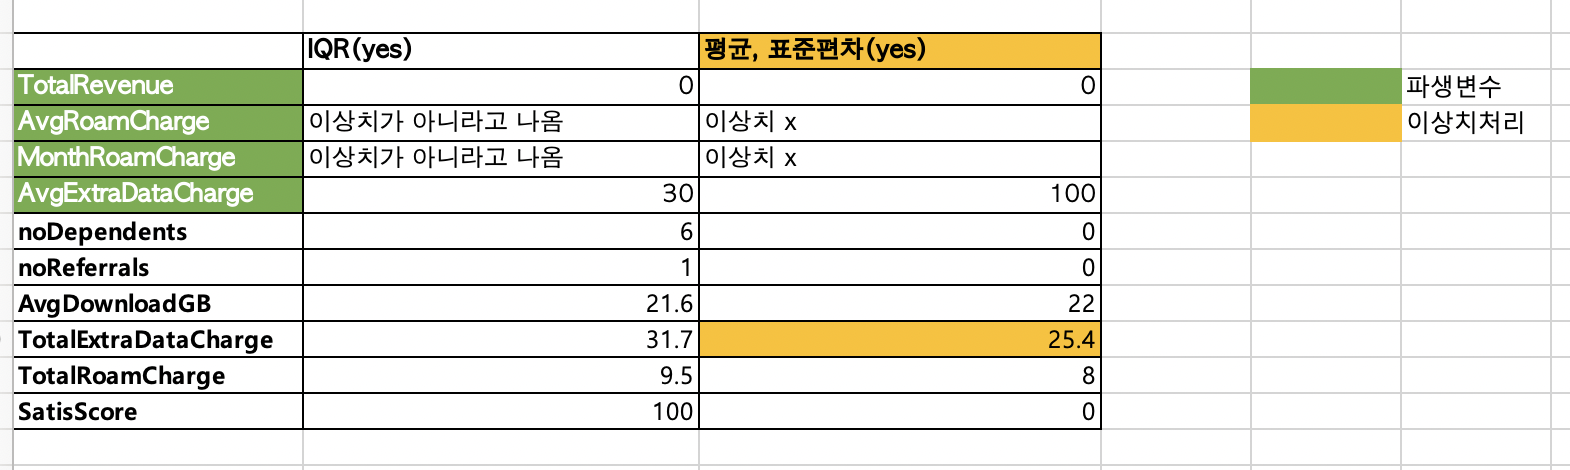


=> 이상치가 아니라고 판단!!     

AvgExtraDataCharge가 TotalExtraDataCharge를 가지고 만든 파생변수로, TotalExtraDataCharge를 대체할 수 있기 때문에 이상치 처리를 모두 하지 않아도 된다고 판단